In [1]:
import scanpy as sc

In [2]:
ad = sc.read_h5ad('/Users/christoffer/work/karolinska/development/metamitoMicS/data/RREAE_5k_raw_only_integration_processed.h5ad')

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [50]:
# 1. Normalize counts per cell (CPM-like, to 1e4 total counts per cell by default)
sc.pp.normalize_total(ad, target_sum=1e4)

# 2. Log1p transform (natural log, log(x+1))
sc.pp.log1p(ad)

In [51]:
ad.obs.cell_type.unique()

['Neurons', 'T cells', 'APCs', 'B cells', 'Macrophages', ..., 'OPCs', 'Dendritic cells', 'DA Oligodendrocytes', 'Astrocyte', 'unclear']
Length: 29
Categories (29, object): ['APCs', 'Activate Mic_Mac 1', 'Activated Mic_Mac 2', 'Astrocyte', ..., 'Stromal cells', 'T cells', 'Vascular cells', 'unclear']

In [60]:
# Replace values in one column
ad.obs["cell_type"] = ad.obs["cell_type"].replace({
    "DA oligodendrocytes": "DA Oligodendrocytes",
})


In [61]:
ad_OL = ad[ad.obs.cell_type.str.contains('DA Oligodendrocytes')]

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the s

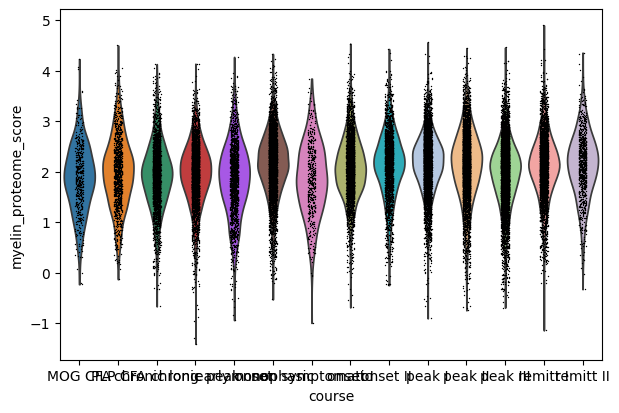

In [62]:
# Assume you have a list of proteomic hits
myelin_proteome_genes = ["Mbp", "Mog", "Cnp", "Mag", "Myrf", "Cldn11", "C4b"]  # extend with Tal’s list

sc.tl.score_genes(ad_OL, myelin_proteome_genes, score_name="myelin_proteome_score")

# Compare across models & courses
sc.pl.violin(ad_OL, keys="myelin_proteome_score", groupby="course")

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


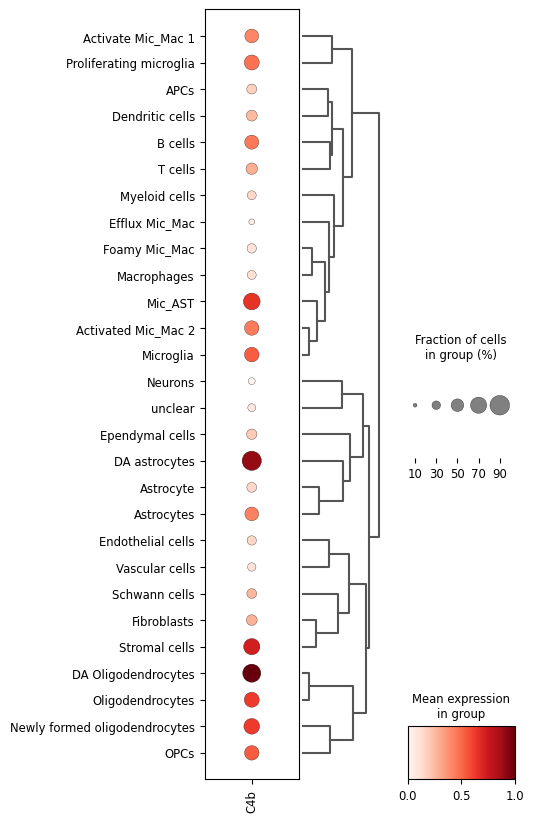

In [138]:
 sc.pl.dotplot(
        ad,
        var_names='C4b',
        groupby="cell_type",
        standard_scale="var",
        #dot_max=0.5,
        #dot_min=0.05,
        color_map="Reds",
        dendrogram=True,
        figsize=(4, 10)
    )

In [146]:
import numpy as np
import pandas as pd

# Subset to DA-oligos only
da_oligos = ad[ad.obs["cell_type"] == "DA Oligodendrocytes", :]

# Extract C4b expression vector
c4b_idx = da_oligos.var_names.get_loc("C4b")
c4b_expr = da_oligos.X[:, c4b_idx].toarray().ravel() if hasattr(da_oligos.X, "toarray") else da_oligos.X[:, c4b_idx].ravel()

# Convert X to dense DataFrame
X = da_oligos.to_df()

# Compute correlations with C4b
cors = X.corrwith(pd.Series(c4b_expr, index=X.index))

# Compute mean expression per gene
means = X.mean()

# Build combined DataFrame
results = pd.DataFrame({
    "gene": cors.index,
    "corr_with_C4b": cors.values,
    "mean_expression": means.values
})

# Sort by correlation
results = results.sort_values("corr_with_C4b", ascending=False).reset_index(drop=True)

# Top 30
top_genes = results.head(50)


In [147]:
top_genes = top_genes[top_genes.corr_with_C4b < 1]

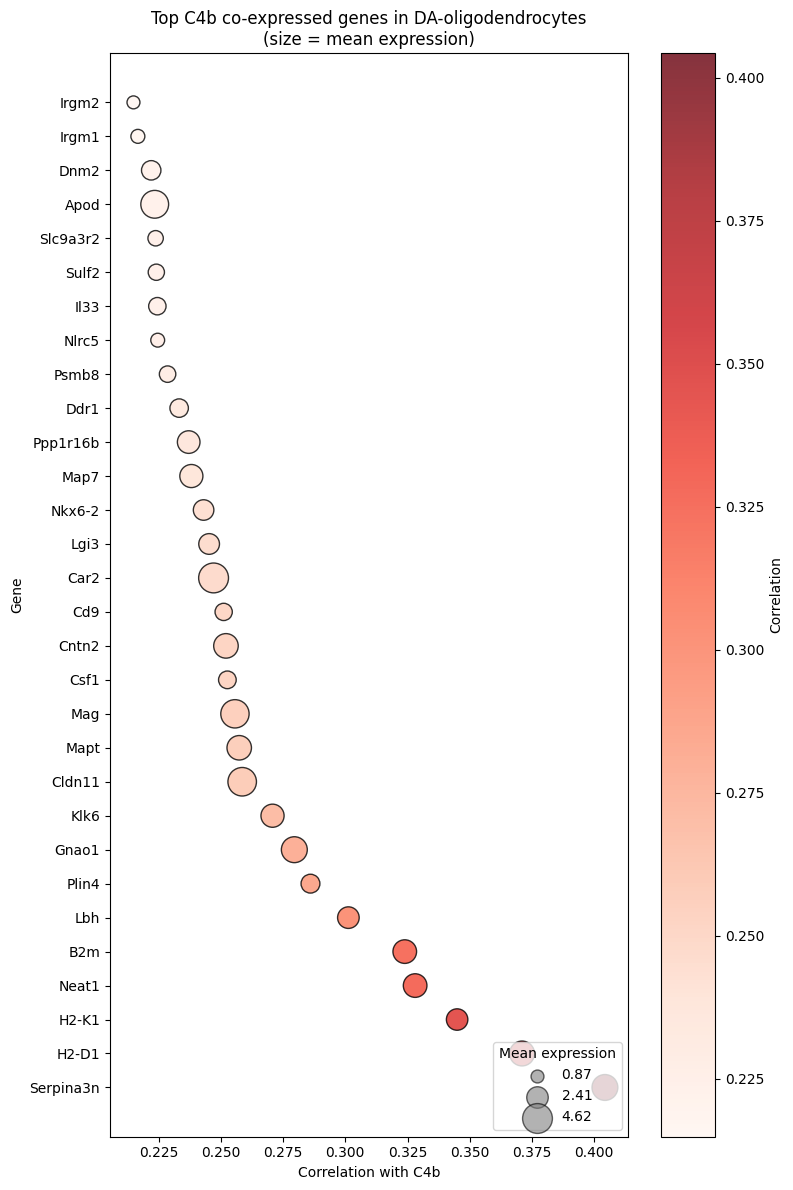

In [149]:
import matplotlib.pyplot as plt

def dotplot_corr_expr(results, top_n=30):
    """
    Dotplot of genes ranked by correlation with C4b.
    Dot size = mean expression, Dot color = correlation with C4b.
    """
    df = results.sort_values("corr_with_C4b", ascending=False).head(top_n)

    plt.figure(figsize=(8, 0.4*top_n))
    sc = plt.scatter(
        x=df["corr_with_C4b"],
        y=df["gene"],
        s=df["mean_expression"]*100,   # scale size by mean expression
        c=df["corr_with_C4b"],
        cmap="Reds",
        alpha=0.8,
        edgecolor="k"
    )

    plt.xlabel("Correlation with C4b")
    plt.ylabel("Gene")
    plt.colorbar(sc, label="Correlation")
    plt.title("Top C4b co-expressed genes in DA-oligodendrocytes\n(size = mean expression)")

    # --- add size legend ---
    handles = []
    sizes = [df["mean_expression"].min(), df["mean_expression"].median(), df["mean_expression"].max()]
    labels = [f"{s:.2f}" for s in sizes]
    for s in sizes:
        handles.append(plt.scatter([], [], s=s*100, color="gray", alpha=0.6, edgecolor="k"))
    plt.legend(handles, labels, title="Mean expression", loc="lower right", frameon=True)

    plt.tight_layout()
    plt.show()

# usage
dotplot_corr_expr(top_genes, top_n=30)

### Patterns in the C4b+ DA-oligo coexpression module
1.	Core immune cluster: *Serpina3n, H2-D1, H2-K1, B2m, Psmb8, Nlrc5, Irgm1*
→ tightly co-expressed, suggesting a strong MHC-I/IFN/innate immunity axis.

2.	Stress/metabolic cluster: *Neat1, Lbh, Plin4, Apod, Sulf2, Slc9a3r2*
→ long noncoding RNA + lipid droplet + oxidative/lipid metabolism → stress/lipid response signature.
3.	OL/myelin/cytoskeletal identity cluster: *Cldn11, Mag, Nkx6-2, Cntn2, Car2, Map7, Mapt, Cd9*
→ myelin structure, cytoskeleton stabilization, OL lineage identity → confirms these are still OLs.
4.	Signaling/adhesion cluster: *Gnao1, Dnm2, Ddr1, Lgi3, Ppp1r16b*
→ suggests cell–cell communication and vesicle/ECM interactions as part of this program.

In [ ]:
from sklearn.linear_model import LassoCV

X = da_oligos.to_df().drop(columns=["C4b"])
y = da_oligos.to_df()["C4b"]

lasso = LassoCV(cv=5).fit(X, y)
coefs = pd.Series(lasso.coef_, index=X.columns)
coefs = coefs[coefs != 0].sort_values(ascending=False)
print(coefs.head(20))

In [150]:
import scanpy as sc

adata_sub = da_oligos[da_oligos[:, "C4b"].X.A.ravel() > 0, :]
sc.pp.pca(adata_sub)
sc.pp.neighbors(adata_sub)
sc.tl.leiden(adata_sub, resolution=0.5)
sc.tl.rank_genes_groups(adata_sub, "leiden", method="wilcoxon")

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
